# Cellpose

github: https://github.com/mouseland/cellpose <br>
data: http://www.cellpose.org/dataset <br>
paper: http://www.cellpose.org/dataset <br>

In [38]:
import numpy as np
import time, os, sys
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
import cellpose
from cellpose import utils, io, models
import os, sys
import glob
import cv2
from shapely.geometry import Polygon
import torch
import importlib
importlib.reload(models)

currentdir = os.path.dirname(os.path.realpath('run_cellpose.ipynb'))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)

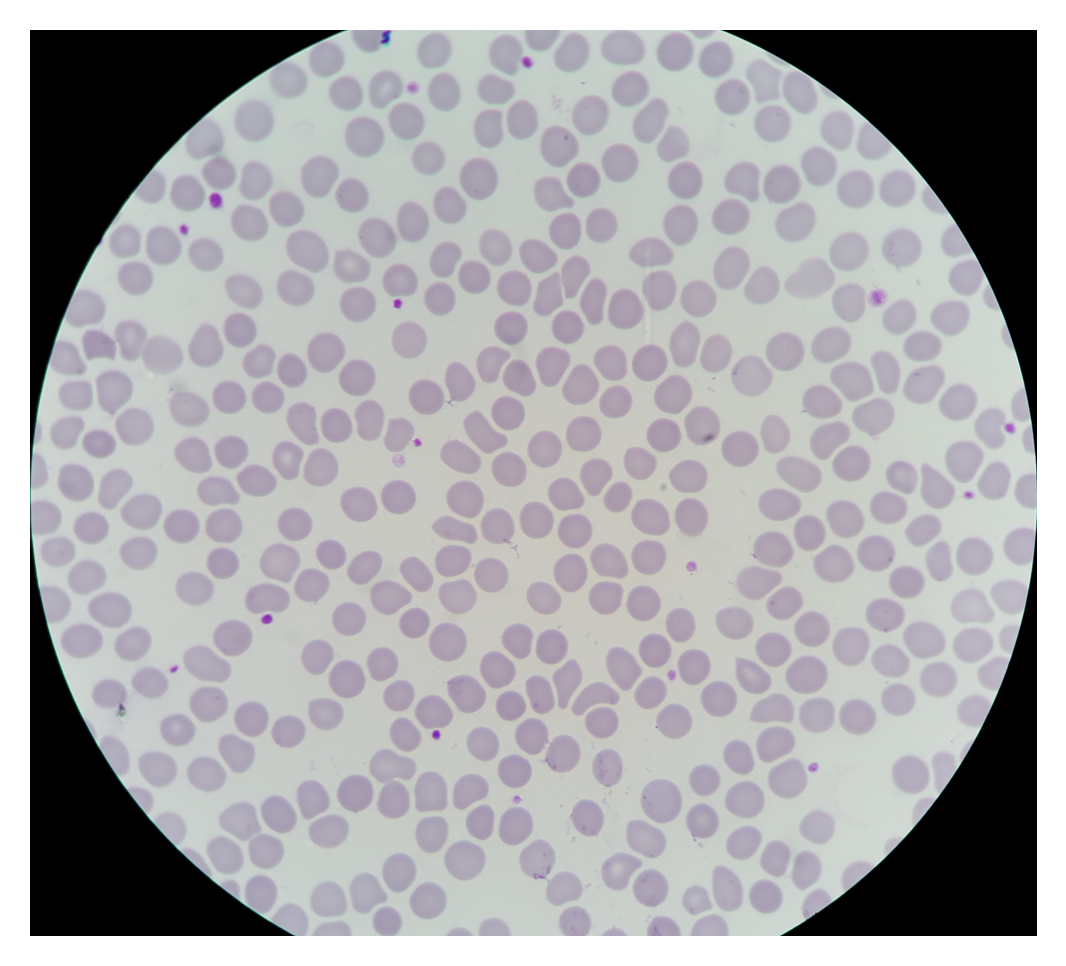

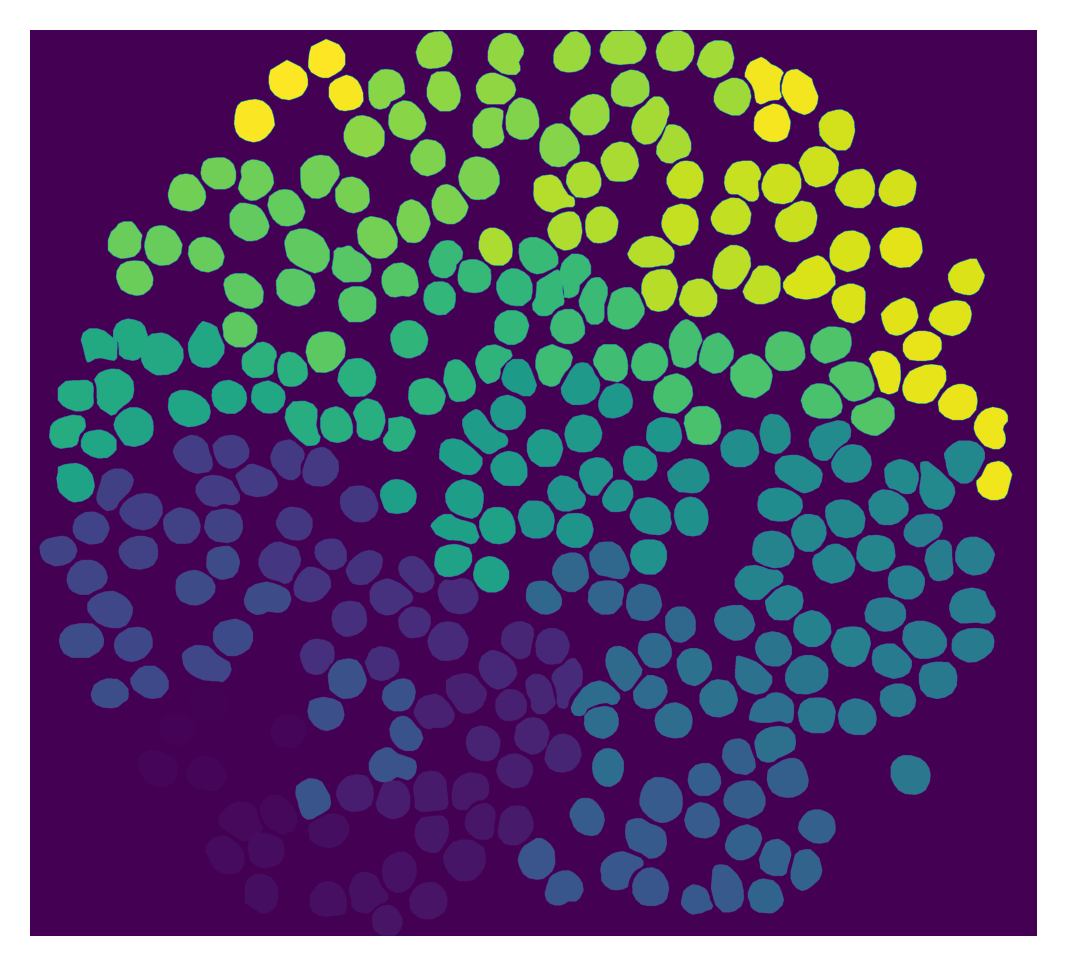

In [3]:
masks_f2c =plt.imread('../data/fit_to_circle/cropped_P206_IMG_20151112_164625.png')
plt.imshow(masks_f2c)
plt.axis('off')
plt.show()
masks_f2c =plt.imread('../data/fit_to_circle/masks_cropped_P206_IMG_20151112_164625_masks.png')
plt.imshow(masks_f2c)
plt.axis('off')
plt.show()

In [4]:
len(np.unique(masks_f2c))

313

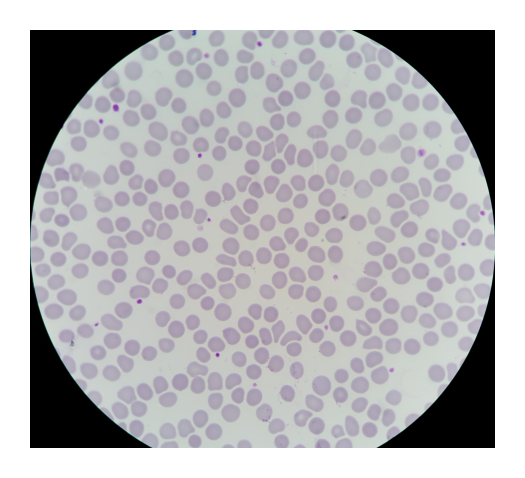

In [5]:
org_files = ['../data/testing_openflexure/2021-03-05_15-50-16_0_0_5578.jpeg', 
            '../data/fit_to_circle/cropped_P201_IMG_20151029_162934.png',
            '../data/fit_to_circle/cropped_P206_IMG_20151112_164625.png',
            ]

# view 1 image
img = io.imread(org_files[-1])
plt.figure(figsize=(2,2))
plt.imshow(img)
plt.axis('off')
plt.show()

In [6]:
def mask_rgb(masks, colors=None):
    """ masks in random rgb colors
    Parameters
    ----------------
    masks: int, 2D array
        masks where 0=NO masks; 1,2,...=mask labels
    colors: int, 2D array (optional, default None)
        size [nmasks x 3], each entry is a color in 0-255 range
    Returns
    ----------------
    RGB: uint8, 3D array
        array of masks overlaid on grayscale image
    """
    if colors is not None:
        if colors.max()>1:
            colors = np.float32(colors)
            colors /= 255
        colors = utils.rgb_to_hsv(colors)
    
    HSV = np.zeros((masks.shape[0], masks.shape[1], 3), np.float32)
    HSV[:,:,2] = 1.0
    for n in range(int(masks.max())):
        ipix = (masks==n+1).nonzero()
        if colors is None:
            HSV[ipix[0],ipix[1],0] = np.random.rand()
        else:
            HSV[ipix[0],ipix[1],0] = colors[n,0]
        HSV[ipix[0],ipix[1],1] = np.random.rand()*0.5+0.5
        HSV[ipix[0],ipix[1],2] = np.random.rand()*0.5+0.5
    RGB = (utils.hsv_to_rgb(HSV) * 255).astype(np.uint8)
    return RGB

def mask_overlay(img, masks, colors=None):
    """ overlay masks on image (set image to grayscale)
    Parameters
    ----------------
    img: int or float, 2D or 3D array
        img is of size [Ly x Lx (x nchan)]
    masks: int, 2D array
        masks where 0=NO masks; 1,2,...=mask labels
    colors: int, 2D array (optional, default None)
        size [nmasks x 3], each entry is a color in 0-255 range
    Returns
    ----------------
    RGB: uint8, 3D array
        array of masks overlaid on grayscale image
    """
    if colors is not None:
        if colors.max()>1:
            colors = np.float32(colors)
            colors /= 255
        colors = utils.rgb_to_hsv(colors)
    if img.ndim>2:
        img = img.astype(np.float32).mean(axis=-1)
    else:
        img = img.astype(np.float32)
    img = utils.normalize99(img)
    img -= img.min()
    img /= img.max()
    HSV = np.zeros((img.shape[0], img.shape[1], 3), np.float32)
    HSV[:,:,2] = np.clip(img*1.5, 0, 1.0)
    for n in range(int(masks.max())):
        ipix = (masks==n+1).nonzero()
        if colors is None:
            HSV[ipix[0],ipix[1],0] = np.random.rand()
        else:
            HSV[ipix[0],ipix[1],0] = colors[n,0]
        HSV[ipix[0],ipix[1],1] = 1.0
    RGB = (utils.hsv_to_rgb(HSV) * 255).astype(np.uint8)
    return RGB

def image_to_rgb(img0, channels=[0,0]):
    """ image is 2 x Ly x Lx or Ly x Lx x 2 - change to RGB Ly x Lx x 3 """
    img = img0.copy()
    img = img.astype(np.float32)
    if img.ndim<3:
        img = img[:,:,np.newaxis]
    if img.shape[0]<5:
        img = np.transpose(img, (1,2,0))
    if channels[0]==0:
        img = img.mean(axis=-1)[:,:,np.newaxis]
    for i in range(img.shape[-1]):
        if np.ptp(img[:,:,i])>0:
            img[:,:,i] = utils.normalize99(img[:,:,i])
            img[:,:,i] = np.clip(img[:,:,i], 0, 1)
    img *= 255
    img = np.uint8(img)
    RGB = np.zeros((img.shape[0], img.shape[1], 3), np.uint8)
    if img.shape[-1]==1:
        RGB = np.tile(img,(1,1,3))
    else:
        RGB[:,:,channels[0]-1] = img[:,:,0]
        if channels[1] > 0:
            RGB[:,:,channels[1]-1] = img[:,:,1]
    return RGB

def interesting_patch(mask, bsize=130):
    """ get patch of size bsize x bsize with most masks """
    Ly,Lx = mask.shape
    m = np.float32(mask>0)
    m = gaussian_filter(m, bsize/2)
    y,x = np.unravel_index(np.argmax(m), m.shape)
    ycent = max(bsize//2, min(y, Ly-bsize//2))
    xcent = max(bsize//2, min(x, Lx-bsize//2))
    patch = [np.arange(ycent-bsize//2, ycent+bsize//2, 1, int),
             np.arange(xcent-bsize//2, xcent+bsize//2, 1, int)]
    return patch

def disk(med, r, Ly, Lx):
    """ returns pixels of disk with radius r and center med """
    yy, xx = np.meshgrid(np.arange(0,Ly,1,int), np.arange(0,Lx,1,int),
                         indexing='ij')
    inds = ((yy-med[0])**2 + (xx-med[1])**2)**0.5 <= r
    y = yy[inds].flatten()
    x = xx[inds].flatten()
    return y,x

In [7]:
imgs = [cv2.imread(img_path) for img_path in org_files]

In [8]:
img_height = 512
img_width = 512
img_channels = 3
imgs_red = np.zeros((len(imgs), img_height, img_width, img_channels), dtype=np.uint8)
sizes_imgs_red = []
for idx, img in enumerate(imgs):
    img_red = cv2.resize(img, (img_height, img_width))
    #Append image to numpy array
    imgs_red[idx] = img_red
    #Append image shape to numpy array
    sizes_imgs_red.append([img_red.shape[0], img_red.shape[1]])

In [9]:
imgs_red[0].shape

(512, 512, 3)

In [10]:
# RUN CELLPOSE


# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'
model = models.Cellpose(gpu=True, model_type='cyto')

# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
# channels = [0,0]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

# or if you have different types of channels in each image
channels = [[0,1], [0,1], [0,0]]

# if diameter is set to None, the size of the cells is estimated on a per image basis
# you can set the average cell `diameter` in pixels yourself (recommended) 
# diameter can be a list or a single number for all images

# you can run all in a list e.g.
# >>> imgs = [io.imread(filename) in files]
# >>> masks, flows, styles, diams = model.eval(imgs, diameter=None, channels=channels)
# >>> io.masks_flows_to_seg(imgs, masks, flows, diams, files, channels)
# >>> io.save_to_png(imgs, masks, flows, files)

# or in a loop
# for chan, img in zip(channels, imgs_red):
masks_all = []

for img in imgs_red:
    chan = [0, 0] # for black and white imgs
    #img = io.imread(filename)
    masks, flows, styles, diams = model.eval(img, diameter=50, channels=chan)

    masks_all.append(masks)
    
    # # save results so you can load in gui
    # io.masks_flows_to_seg(img, masks, flows, diams, filename, chan)

    # # save results as png
    # io.save_to_png(img, masks, flows, filename)

Downloading: "https://www.cellpose.org/models/cyto_0" to /root/.cellpose/models/cyto_0
100%|██████████| 25.2M/25.2M [00:01<00:00, 13.9MB/s]
Downloading: "https://www.cellpose.org/models/cyto_1" to /root/.cellpose/models/cyto_1
100%|██████████| 25.2M/25.2M [00:01<00:00, 15.4MB/s]
Downloading: "https://www.cellpose.org/models/cyto_2" to /root/.cellpose/models/cyto_2
100%|██████████| 25.2M/25.2M [00:01<00:00, 15.5MB/s]
Downloading: "https://www.cellpose.org/models/cyto_3" to /root/.cellpose/models/cyto_3
100%|██████████| 25.2M/25.2M [00:06<00:00, 4.36MB/s]
Downloading: "https://www.cellpose.org/models/size_cyto_0.npy" to /root/.cellpose/models/size_cyto_0.npy
100%|██████████| 3.55k/3.55k [00:00<00:00, 5.23MB/s]
Downloading: "https://www.cellpose.org/models/cytotorch_0" to /root/.cellpose/models/cytotorch_0
100%|██████████| 25.3M/25.3M [00:02<00:00, 9.95MB/s]
Downloading: "https://www.cellpose.org/models/cytotorch_1" to /root/.cellpose/models/cytotorch_1
100%|██████████| 25.3M/25.3M [00:02

** TORCH CUDA version installed and working. **
>>>> using GPU
processing 1 image(s)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3829: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


time spent: running network 0.79s; flow+mask computation 0.32
estimated masks for 1 image(s) in 1.15 sec
>>>> TOTAL TIME 1.15 sec
processing 1 image(s)
time spent: running network 0.36s; flow+mask computation 0.45
estimated masks for 1 image(s) in 0.81 sec
>>>> TOTAL TIME 0.81 sec
processing 1 image(s)
time spent: running network 0.34s; flow+mask computation 0.51
estimated masks for 1 image(s) in 0.86 sec
>>>> TOTAL TIME 0.86 sec


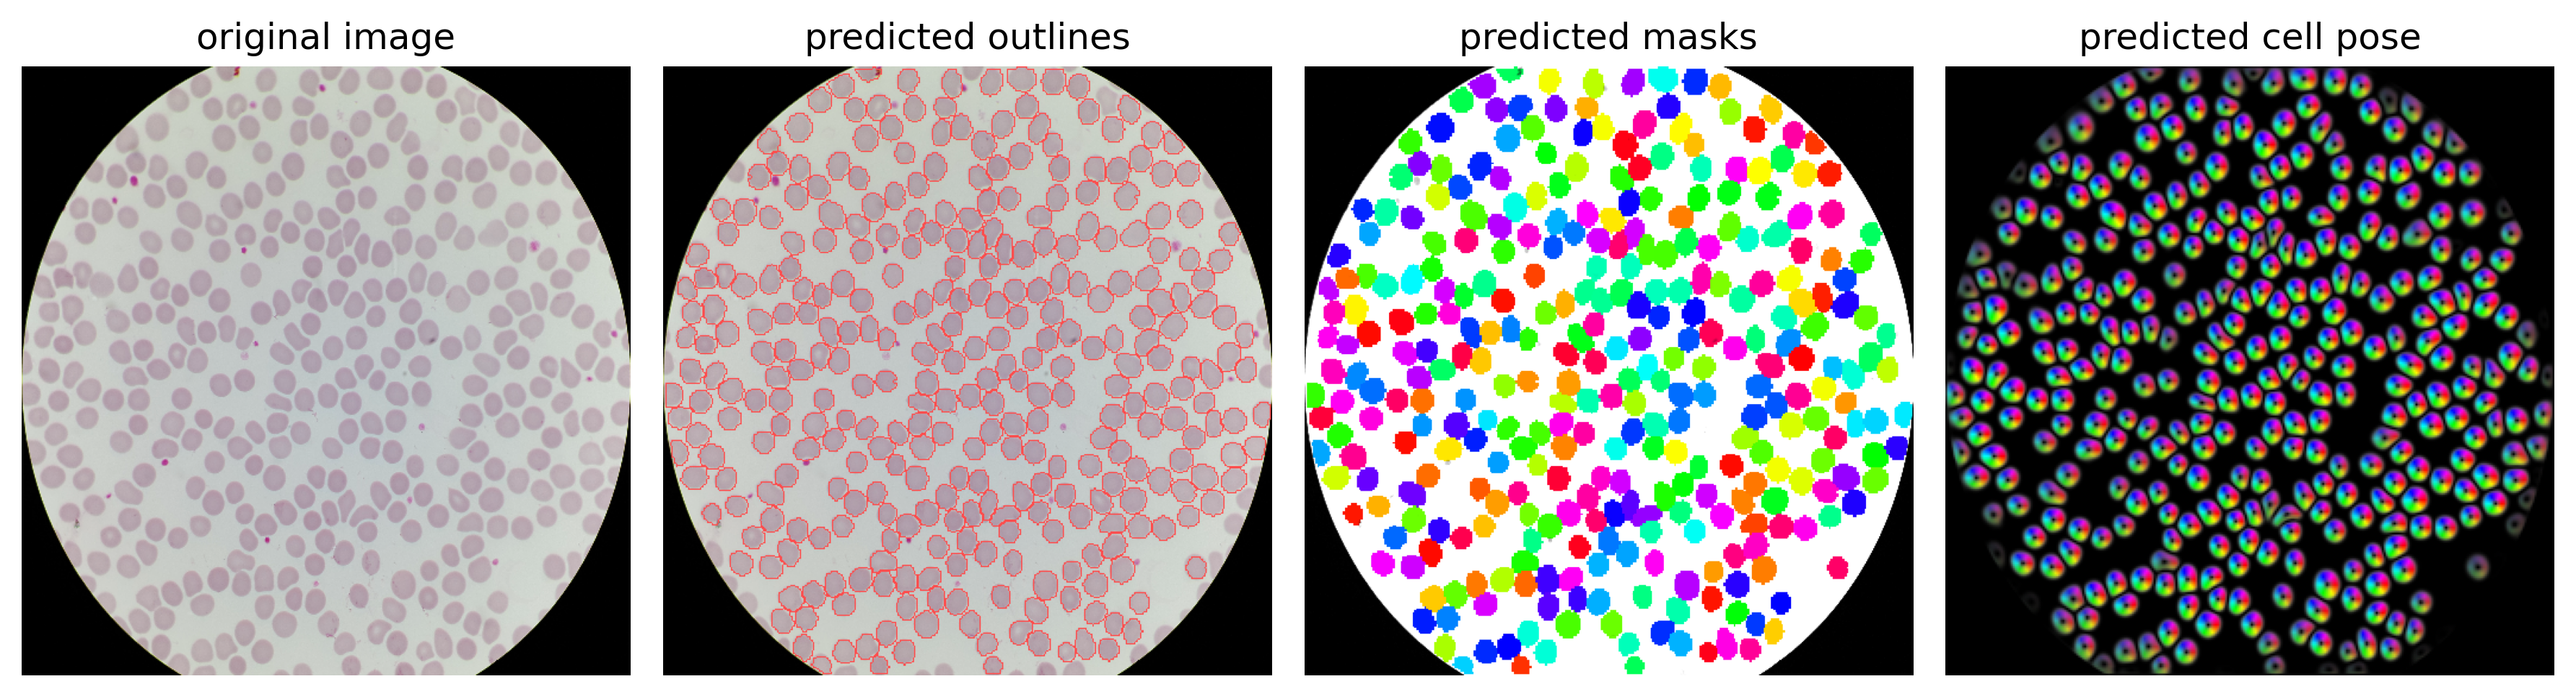

In [11]:
# DISPLAY RESULTS
from cellpose import plot

fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, img, masks, flows[0], channels=chan)
plt.tight_layout()
plt.show()

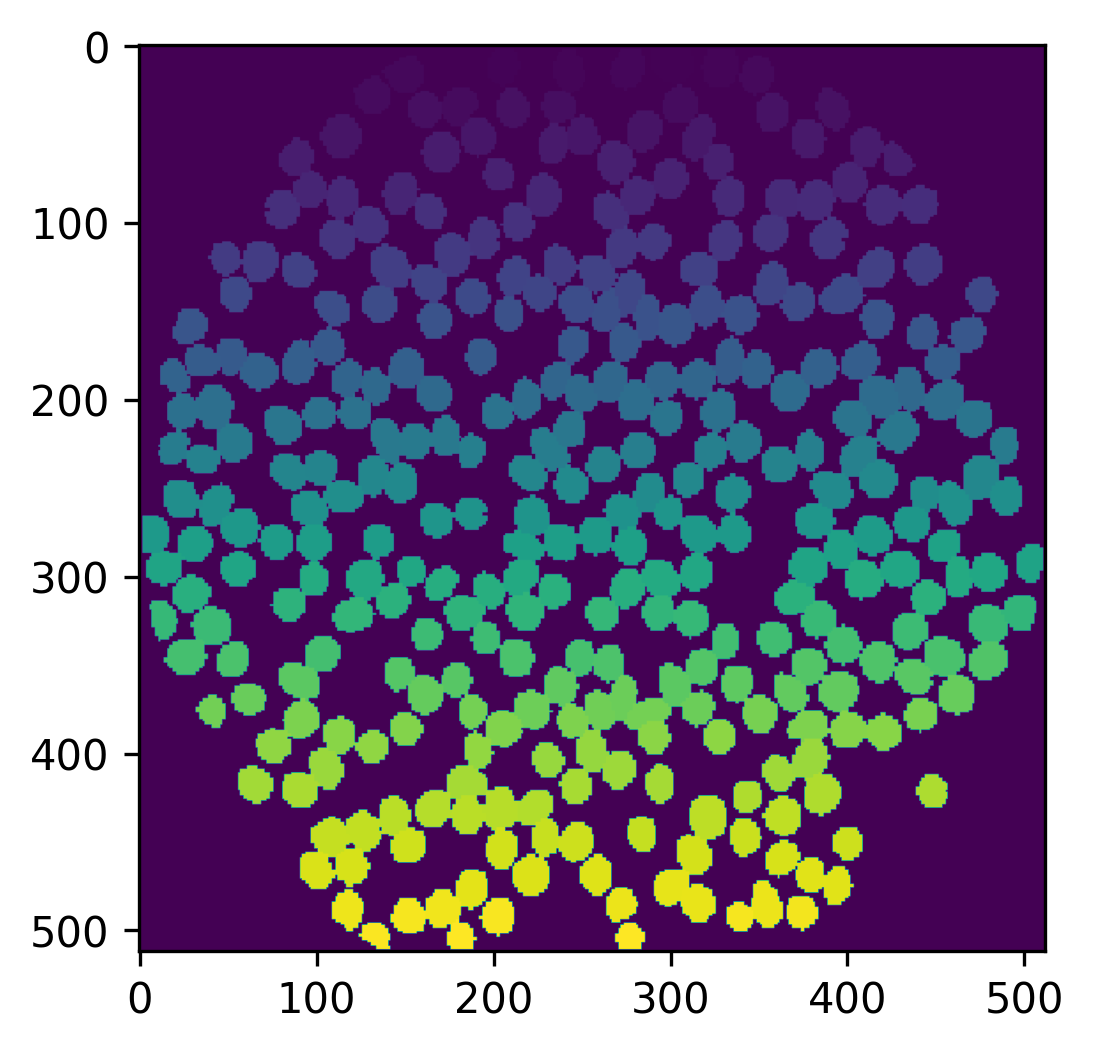

In [12]:
plt.imshow(masks)

(-0.5, 511.5, 511.5, -0.5)

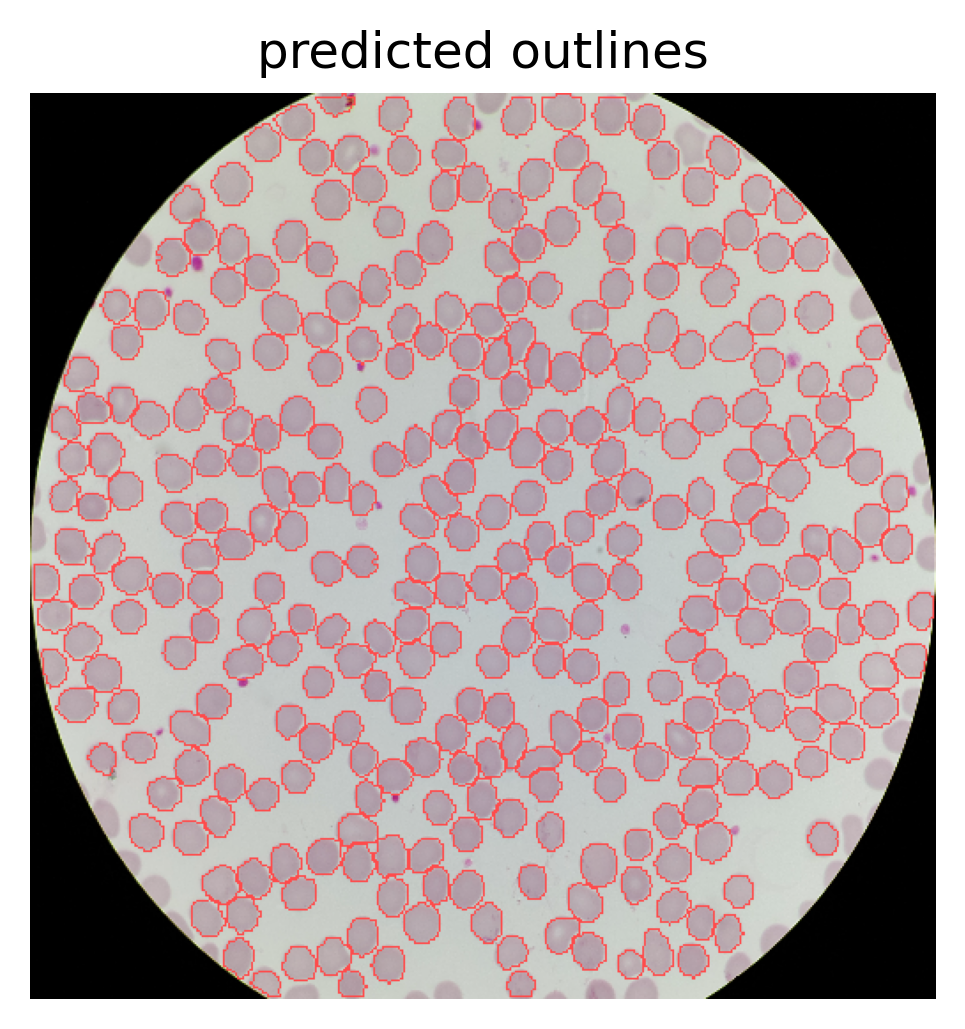

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
outlines = utils.masks_to_outlines(masks_all[-1])
outX, outY = np.nonzero(outlines)
imgout= imgs_red[-1].copy()
imgout[outX, outY] = np.array([255,75,75])
ax.imshow(imgout)
#for o in outpix:
#    ax.plot(o[:,0], o[:,1], color=[1,0,0], lw=1)
ax.set_title('predicted outlines')
ax.axis('off')

# Retrain with NIH Data

In [41]:
torch.cuda.get_device_name(0)

'GeForce GTX 1080 Ti'

https://github.com/MouseLand/cellpose/blob/5cc03de9c2aa342d4b4469ff476ca04541b63414/docs/train.rst

Following the comments of https://github.com/MouseLand/cellpose/issues/211 <br>
I changed line 316 of /usr/local/lib/python3.6/dist-packages/cellpose/models.py to <br>
   def __init__(self, **gpu=True**, pretrained_model=False, torch=True, ...

In [ ]:
!python -m cellpose \
--train \
--use_gpu \
--dir ../data/fit_to_circle/train/ \
--test_dir ../data/fit_to_circle/test/ \
--pretrained_model None

** TORCH CUDA version installed and working. **
>>>> using GPU
>>>> training from scratch
>>>> during training rescaling images to fixed diameter of 30.0 pixels
NOTE: computing flows for labels (could be done before to save time)
  0%|                                                   | 0/132 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|█████████████████████████████████████████| 132/132 [00:55<00:00,  2.39it/s]
NOTE: computing flows for labels (could be done before to save time)
100%|███████████████████████████████████████████| 33/33 [00:07<00:00,  4.70it/s]
>>>> training network with 2 channel input <<<<
>>>> saving every 100 epochs
>>>> median diameter = 30
>>>> LR: 0.20000, batch_size: 8, weight_decay: 0.00001
>>>> ntr

In [ ]:
!python -m cellpose \
--train \
--use_gpu \
--dir ../data/fit_to_circle/train/ \
--test_dir ../data/fit_to_circle/test/ \
--pretrained_model cyto